<a href="https://colab.research.google.com/github/XENOXI/Iishenka/blob/main/lab2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q kaggle
!cp kaggle.json ~/.kaggle/
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d alexattia/the-simpsons-characters-dataset

cp: cannot stat 'kaggle.json': No such file or directory


Saving kaggle.json to kaggle.json
100% 1.08G/1.08G [01:01<00:00, 21.2MB/s]
100% 1.08G/1.08G [01:01<00:00, 18.8MB/s]


In [2]:
!unzip the-simpsons-characters-dataset.zip
!rm -rf the-simpsons-characters-dataset.zip 
!rm -rf simpsons_dataset/simpsons_dataset

Выходные данные были обрезаны до нескольких последних строк (5000).
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1271.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1272.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1273.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1274.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1275.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1276.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1277.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1278.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1279.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1280.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1281.jpg  
  inflating: simpsons_dataset/simpsons_dataset/moe_szyslak/pic_1282.jpg  
  inflating: simpsons_dataset/simpsons_datas

In [ ]:
!nvidia-smi

Mon Mar 20 16:06:21 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0    32W /  70W |   4633MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
import torch
torch.cuda.is_available()

True

In [4]:
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader, random_split

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.fc1 = nn.Linear(64 *124 * 124, 128)
        self.fc2 = nn.Linear(128, 42)

    def forward(self, x):
        x = nn.functional.relu (self.conv1(x))
        x = nn.functional.relu (self.conv2(x))
        x = x.view(-1, 64 * 124 * 124)
        x = nn.functional.relu (self.fc1 (x))
        x = self.fc2 (x)
        return x



transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
data_set =  datasets.ImageFolder("simpsons_dataset", transform=transform)

valid_count = int(len(data_set)*0.1)
train_set, valid_set = random_split(data_set,[len(data_set)-valid_count,valid_count])
train_loader = torch.utils.data.DataLoader(train_set, batch_size = 32, shuffle = True)
validate_loader = torch.utils.data.DataLoader(valid_set, batch_size = 32, shuffle = True)


In [ ]:
len(train_loader)

555

In [6]:
model = Net().cuda()
criterion = nn.CrossEntropyLoss().cuda()
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9)


accuracy_per_epoch = []
running_loss_per_epoch = []
validation_loss_per_epoch = []
for epoch in range(10):

    running_loss = 0.0
    buff = 0
    accuracy = 0
    for i,data in enumerate(train_loader, 0):
        x, label = data
        x = x.cuda()
        label = label.cuda()
        optimizer.zero_grad()
        y = model(x)
        loss = criterion(y, label)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        
        accuracy += sum(y.argmax(dim=1)==label).to('cpu').item()
        if i % 100 == 99:
            print('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, (running_loss-buff) / 100))
            buff = running_loss
    accuracy_per_epoch.append(accuracy/32/len(train_loader))
    running_loss_per_epoch.append(running_loss/32/len(train_loader))

    #validation
    running_loss = 0.0
    for i,data in enumerate(validate_loader, 0):
        x, label = data
        x = x.cuda()
        label = label.cuda()
        y = model(x)
        loss = criterion(y, label)
        running_loss += loss.item()
    validation_loss_per_epoch.append(running_loss/32/len(validate_loader))

    


[1,   100] loss: 3.025
[1,   200] loss: 2.466
[1,   300] loss: 2.254
[1,   400] loss: 2.035
[1,   500] loss: 1.901
[2,   100] loss: 1.570
[2,   200] loss: 1.617
[2,   300] loss: 1.588
[2,   400] loss: 1.577
[2,   500] loss: 1.486
[3,   100] loss: 1.167
[3,   200] loss: 1.210
[3,   300] loss: 1.200
[3,   400] loss: 1.212
[3,   500] loss: 1.168
[4,   100] loss: 0.891
[4,   200] loss: 0.840
[4,   300] loss: 0.844
[4,   400] loss: 0.928
[4,   500] loss: 0.944
[5,   100] loss: 0.533
[5,   200] loss: 0.595
[5,   300] loss: 0.543
[5,   400] loss: 0.600
[5,   500] loss: 0.607
[6,   100] loss: 0.297
[6,   200] loss: 0.311
[6,   300] loss: 0.356
[6,   400] loss: 0.396
[6,   500] loss: 0.366
[7,   100] loss: 0.202
[7,   200] loss: 0.181
[7,   300] loss: 0.182
[7,   400] loss: 0.182
[7,   500] loss: 0.180
[8,   100] loss: 0.098
[8,   200] loss: 0.075
[8,   300] loss: 0.106
[8,   400] loss: 0.165
[8,   500] loss: 0.095
[9,   100] loss: 0.091
[9,   200] loss: 0.119
[9,   300] loss: 0.115
[9,   400] 

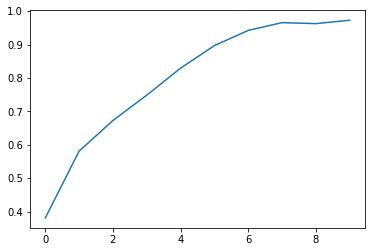

In [7]:
import matplotlib.pyplot as plt

plt.plot(accuracy_per_epoch)

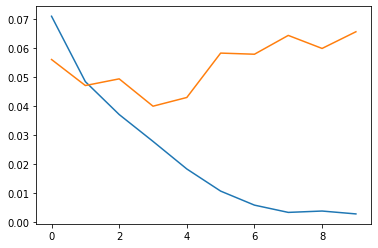

In [8]:
plt.plot(running_loss_per_epoch)
plt.plot(validation_loss_per_epoch)

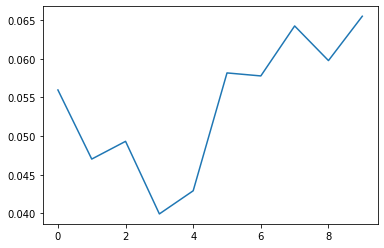

tensor(25, device='cuda:0') milhouse_van_houten


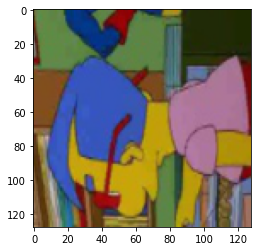

In [ ]:
import numpy as np
import os

%matplotlib inline

transform = transforms.Compose([transforms.Resize((128, 128)), transforms.ToTensor()])
test_set =  datasets.ImageFolder("kaggle_simpson_testset", transform=transform)
test_loader = torch.utils.data.DataLoader(test_set, batch_size = 32, shuffle = True)

accurancy = 0.0
for i,data in enumerate(test_loader, 0):
  content = os.listdir('simpsons_dataset')
  content.sort()
  x, label = data
  plt.imshow(np.swapaxes(x[0], 2,0))
  x = x.cuda()
  label = label
  optimizer.zero_grad()
  y = model(x)
  print(y[0].argmax(),content[y[0].argmax()])
  plt.show()
  break
    



# Новый раздел

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
torch.save(model.state_dict(),"myWeight")